In [1]:
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as au
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import xarray as xr
import pandas as pd

In [2]:
from read_vtk import read_vtk

In [3]:
fname_vtk = './fbtest.0030.vtk'
ds = read_vtk(fname_vtk)

In [4]:
# List of available 3d data cube. We will need density, velocity, temperature, and electron fraction (xe).
ds.field_list

['density',
 'velocity',
 'pressure',
 'temperature',
 'temperature_dust',
 'heat_rate',
 'cool_rate',
 'net_cool_rate',
 'rad_energy_density_PH',
 'rad_energy_density_LW',
 'rad_energy_density_PE',
 'rad_energy_density_LW_diss',
 'specific_scalar[0]',
 'specific_scalar[1]',
 'xHI',
 'xH2',
 'xe',
 'xCI_over_xCtot']

#### Simulation domain and unit information

- The code unit for length is parsec.
- The code unit for velocity is km/s.
- The code unit for density is set such that rho_code=1 corresponds to nH=1/cm^3.
- Left/right edge
- Lx: domain size
- dx[0] : dx
- dx[1] : dy
- dx[2] : dz

In [5]:
# Simulation domain information
ds.domain

{'all_grid_equal': True,
 'ngrid': 1,
 'le': array([-40., -40., -40.], dtype=float32),
 're': array([40., 40., 40.], dtype=float32),
 'dx': array([0.3125, 0.3125, 0.3125], dtype=float32),
 'Lx': array([80., 80., 80.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([256, 256, 256]),
 'ndim': 3,
 'time': 3.000897}

In [6]:
# code unit are stored as astropy.units objects
ds.u.length, ds.u.mass, ds.u.time, ds.u.velocity 

(<Quantity 1. pc>,
 <Quantity 0.03529472 solMass>,
 <Quantity 3.08567758e+13 s>,
 <Quantity 1. km / s>)

In [7]:
# To convert code time to Myr, we can multiply code_time by u.Myr
# That is, u.Myr = code.time.to('Myr').value
ds.u.Myr, ds.u.kms, ds.u.Msun, ds.u.pc, ds.u.pc

(0.9777922216807893, 1.0, 0.035294721634998916, 1.0, 1.0)

In [8]:
dd = ds.get_field(['density', 'velocity', 'temperature', 'xe'])
dd

<xarray.Dataset>
Dimensions:      (z: 256, y: 256, x: 256)
Coordinates:
  * x            (x) float64 -39.84 -39.53 -39.22 -38.91 ... 39.22 39.53 39.84
  * y            (y) float64 -39.84 -39.53 -39.22 -38.91 ... 39.22 39.53 39.84
  * z            (z) float64 -39.84 -39.53 -39.22 -38.91 ... 39.22 39.53 39.84
Data variables:
    density      (z, y, x) float32 0.3292 0.3336 0.3395 ... 0.2038 0.2017 0.1992
    velocity1    (z, y, x) float32 -3.201 -3.191 -3.178 ... 0.957 0.9303 0.8666
    velocity2    (z, y, x) float32 -6.694 -6.623 -6.506 ... 5.46 5.606 5.655
    velocity3    (z, y, x) float32 0.626 0.5539 0.4627 ... 2.079 2.244 2.32
    temperature  (z, y, x) float32 9.017e+03 8.844e+03 ... 7.968e+03 7.985e+03
    xe           (z, y, x) float32 0.1553 0.134 0.1147 0.08631 ... 1.0 1.0 1.0
Attributes:
    all_grid_equal:  True
    ngrid:           1
    le:              [-40. -40. -40.]
    re:              [40. 40. 40.]
    dx:              [0.3125 0.3125 0.3125]
    Lx:              [80. 80. 80.]
    center:          [0. 0. 0.]
    Nx:              [256 256 256]
    ndim:            3
    time:            3.000897

In [9]:
# Numpy array can be accessed using ".data"
type(dd['x'].data), type(dd['density'].data), dd['x'].data.shape, dd['density'].data.shape

(numpy.ndarray, numpy.ndarray, (256,), (256, 256, 256))

In [10]:
# Rename field names
dd = dd.rename({'density':'nH', 'velocity1':'vx','velocity2':'vy','velocity3':'vz','temperature':'T'})
dd['ne'] = dd['nH']*dd['xe']
dd['nesq'] = dd['ne']**2

### Compute Halpha emissivity

* Caution: Draine (2011)'s alpha_eff_Halpha valid for ~1000 K < T < ~30000 K
* Better to use this for warm gas only

In [11]:
hnu_Halpha = (ac.h*ac.c/(6562.8*au.angstrom)).to('erg')
alpha_eff_Halpha = lambda T: 1.17e-13*(T*1e-4)**(-0.942-0.031*np.log(T*1e-4))
dd['j_Halpha'] = dd['nesq']*alpha_eff_Halpha(dd['T'])*hnu_Halpha/(4.0*np.pi)
dd

<xarray.Dataset>
Dimensions:   (z: 256, y: 256, x: 256)
Coordinates:
  * x         (x) float64 -39.84 -39.53 -39.22 -38.91 ... 39.22 39.53 39.84
  * y         (y) float64 -39.84 -39.53 -39.22 -38.91 ... 39.22 39.53 39.84
  * z         (z) float64 -39.84 -39.53 -39.22 -38.91 ... 39.22 39.53 39.84
Data variables:
    nH        (z, y, x) float32 0.3292 0.3336 0.3395 ... 0.2038 0.2017 0.1992
    vx        (z, y, x) float32 -3.201 -3.191 -3.178 ... 0.957 0.9303 0.8666
    vy        (z, y, x) float32 -6.694 -6.623 -6.506 -6.333 ... 5.46 5.606 5.655
    vz        (z, y, x) float32 0.626 0.5539 0.4627 0.3373 ... 2.079 2.244 2.32
    T         (z, y, x) float32 9.017e+03 8.844e+03 ... 7.968e+03 7.985e+03
    xe        (z, y, x) float32 0.1553 0.134 0.1147 0.08631 ... 1.0 1.0 1.0 1.0
    ne        (z, y, x) float32 0.05112 0.04471 0.03895 ... 0.2038 0.2017 0.1992
    nesq      (z, y, x) float32 0.002613 0.001999 0.001517 ... 0.04068 0.0397
    j_Halpha  (z, y, x) float32 8.114e-29 6.321e-29 ... 1.418e-27 1.381e-27
Attributes:
    all_grid_equal:  True
    ngrid:           1
    le:              [-40. -40. -40.]
    re:              [40. 40. 40.]
    dx:              [0.3125 0.3125 0.3125]
    Lx:              [80. 80. 80.]
    center:          [0. 0. 0.]
    Nx:              [256 256 256]
    ndim:            3
    time:            3.000897

In [12]:
# Integration along the z-axis (face on view)
dz = ds.domain['dx'][2]*ac.pc.cgs # Delta z in cm
NH = dd['nH'].sum(dim='z')*dz.cgs.value # Hydrogen column [cm^-2]
dz.to('pc')

<Quantity 0.3125 pc>

### Plot density projection NH

<xarray.DataArray 'nH' (y: 1, x: 1)>
array([[4.8849843e+22]], dtype=float32)
Coordinates:
  * x        (x) float64 2.656
  * y        (y) float64 0.7812

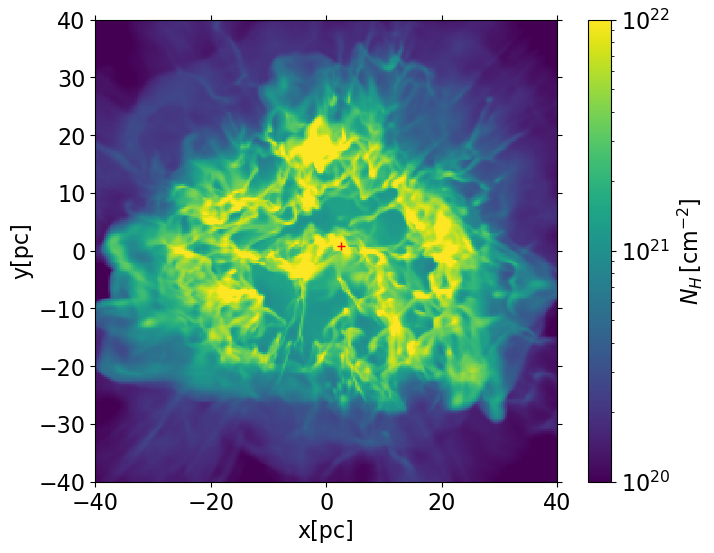

In [13]:
plt.pcolormesh(dd['x'],dd['y'],NH,norm=LogNorm(1e20,1e22),shading='nearest')
#plt.pcolormesh(dd['x'],dd['y'],NH,norm=Normalize(0, 1e22),shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('y[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

# Mark the position where NH is maximum
NHmax = NH.where(NH == NH.max(), drop=True)
plt.plot(NHmax.x,NHmax.y,'r+')
NHmax

### Emission measure

In [14]:
# Integration along the z-axis (face on view)
dz_pc = ds.domain['dx'][2] # Delta z in pc
dd['nesq'] = (dd['nH']*dd['xe'])**2

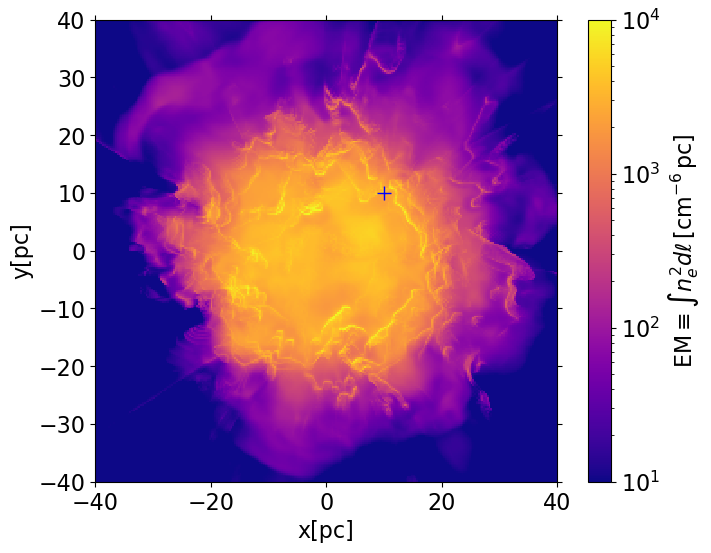

In [15]:
plt.pcolormesh(dd['x'],dd['y'],dd['nesq'].sum(dim='z')*dz_pc,norm=LogNorm(1e1,1e4),
               cmap=plt.cm.plasma,shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('y[pc]')
cbar = plt.colorbar(label=r'${\rm EM}\equiv \int n_e^2 d\ell\,[{\rm cm}^{-6}\,{\rm pc}]$')

x_los = 10
y_los = 10
plt.plot(x_los, y_los,'b+',ms=10)

## Profile along a single line of sight

In [16]:
# los = dd[['nH','T','vz']].sel(x=NHmax.x, y=NHmax.y, method='nearest').squeeze()
los = dd.sel(x=x_los,y=x_los, method='nearest').squeeze()

Text(0, 0.5, '$T\\;[{\\rm K}]$')

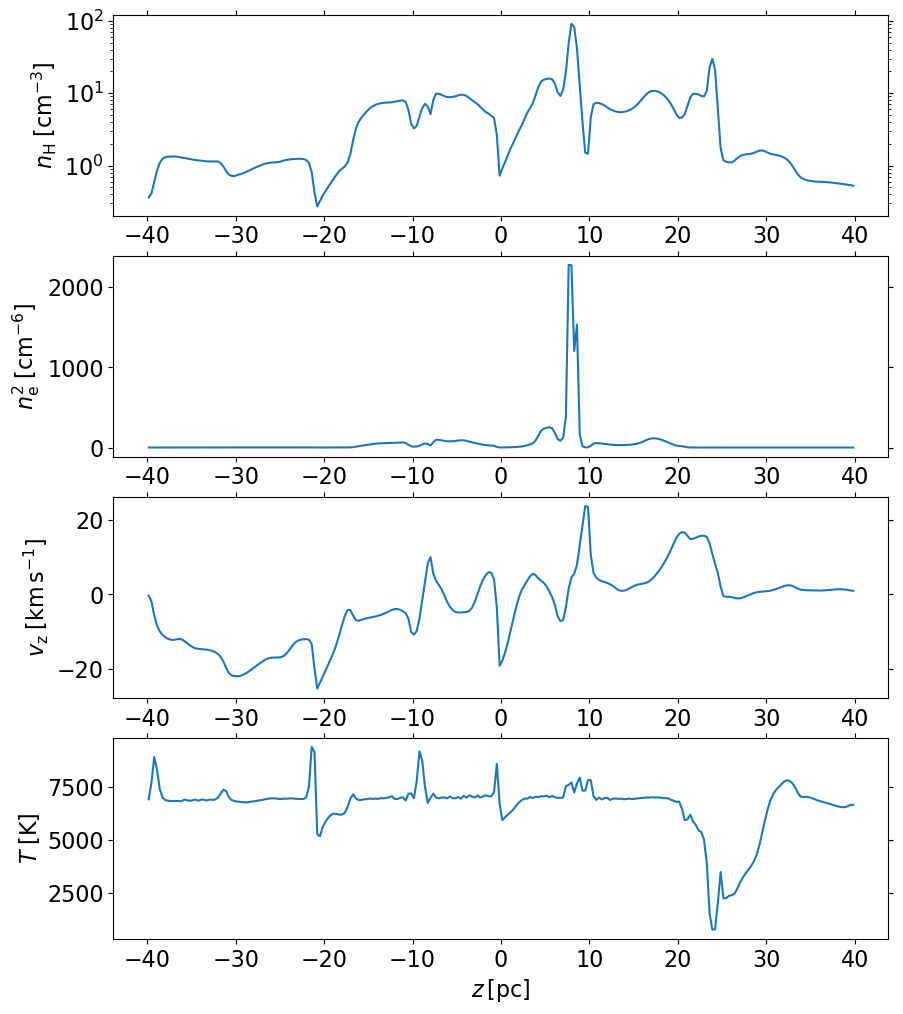

In [17]:
fig,axes = plt.subplots(4,1,figsize=(10,12))
axes[0].semilogy(los['z'],los['nH'], label='nH')
axes[1].plot(los['z'],los['nesq'], label='nesq')
axes[2].plot(los['z'],los['vz'], label='vz')
axes[3].plot(los['z'],los['T'], label='T')

plt.setp(axes, xlabel=r'$z\,[{\rm pc}]$')
axes[0].set_ylabel(r'$n_{\rm H}\;[{\rm cm}^{-3}]$')
axes[1].set_ylabel(r'$n_{\rm e}^2\;[{\rm cm}^{-6}]$')
axes[2].set_ylabel(r'$v_{\rm z}\;[{\rm km}\,{\rm s}^{-1}]$')
axes[3].set_ylabel(r'$T\;[{\rm K}]$')

## Histogram of radial velocity

In [18]:
dd['vr'] = np.sqrt(dd['vx']**2 + dd['vy']**2 + dd['vz']**2)

Text(0, 0.5, '$n_{\\rm e}^2$-weighted histogram')

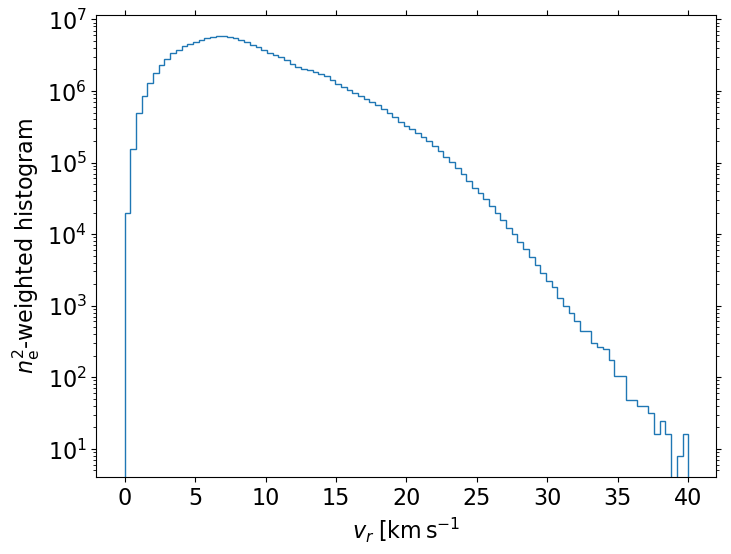

In [19]:
plt.hist(dd['vr'].data.flatten(),bins=np.linspace(0,40,100),
         weights=dd['nesq'].data.flatten(),histtype='step');
plt.yscale('log')
plt.xlabel(r'$v_{r}\;[{\rm km}\,{\rm s}^{-1}$')
plt.ylabel(r'$n_{\rm e}^2$-weighted histogram')

In [20]:
hnu_Halpha = (ac.h*ac.c/(6562.8*au.angstrom)).to('erg')
alpha_eff_Halpha = lambda T: 1.17e-13*(T*1e-4)**(-0.942-0.031*np.log(T*1e-4))
dd['j_Halpha'] = dd['nesq']*alpha_eff_Halpha(dd['T'])*hnu_Halpha/(4.0*np.pi)

### Line proflie function


* Intrinsic line width is assumed to be much smaller than thermal width.

\begin{equation}
\phi_{\nu} \approx \frac{1}{\sqrt{\pi}}\frac{1}{\nu_{ul}} \frac{c}{b} \exp ( -v^2/b^2 )
\end{equation}

or using $\phi_{\lambda} d\lambda = \phi_{\nu} d\nu$

\begin{equation}
\phi_{\lambda} \approx \frac{1}{\sqrt{\pi}}\frac{1}{\lambda_{ul}} \frac{c}{b} \exp ( -v^2/b^2 )
\end{equation}


where the broadening parameter $b \equiv \sqrt{2}\sigma_v$ is

\begin{equation}
b = \left( \frac{2 k_{\rm B} T}{T} \right)^{1/2} = 12.9 \left( \frac{T_4}{M/{\rm amu}} \right)^{1/2}\,{\rm km}\,{\rm s}^{-1}
\end{equation}

In [21]:
v0 = 0.0
l_Halpha = (6562.8*au.angstrom).value
c_kms = ac.c.to('km s-1').value
m_H = ac.m_p
Tion = 8000.0*au.K
b_kms = (np.sqrt(2.0*ac.k_B*Tion/m_H)).to('km s-1').value
# the actual absorption cross section is somewhat smaller than this value 
# see, e.g., Fig 20 in KimJG et al. (2023)
sigma_dust = (1.0e-21*au.cm**2).cgs.value
b_kms,l_Halpha,c_kms

(11.49218848207788, 6562.8, 299792.458)

In [22]:
Nv = 30
v_ch = np.linspace(-50, 50, Nv) # velocity channel
ds_cgs = (ds.domain['dx'][0]*ac.pc).cgs.value # Path length for one cell (cm)
sigma_dust, los['nH'].shape, los['T'].shape, los['vz'].shape, ds_cgs,

(1e-21, (256,), (256,), (256,), 9.642742442160522e+17)

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 792.63it/s]


Text(0.5, 0, '$v_{\\rm ch}\\;[{\\rm km}\\,{\\rm s}^{-1}$')

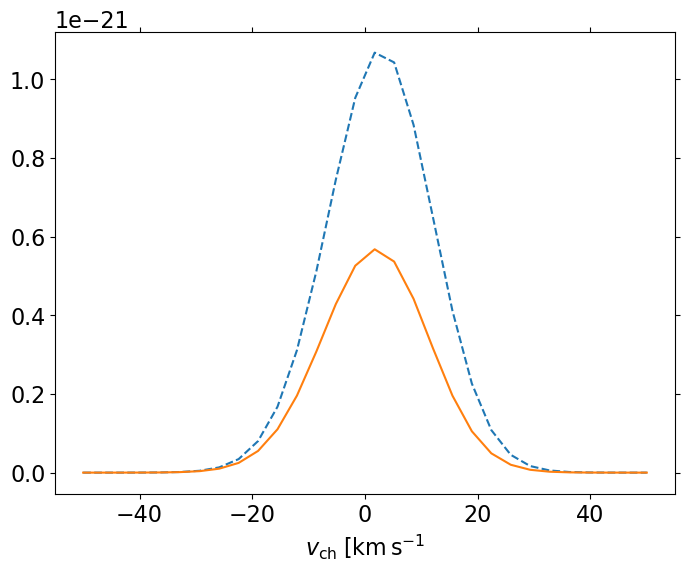

In [23]:
from synthetic_Halpha import calc_los_IHalpha
## Single line of sight
v0 = los['vz']
nH = los['nH']
j_Halpha = los['j_Halpha']
I, I_thin = calc_los_IHalpha(v_ch, j_Halpha, nH, v0, ds_cgs, sigma_dust, los_axis=0, verbose=True)
plt.plot(v_ch, I_thin, '--')
plt.plot(v_ch, I)
plt.xlabel(r'$v_{\rm ch}\;[{\rm km}\,{\rm s}^{-1}$')
#plt.ylabel(r'$I_{\rm H\alpha} \equiv \int $')

In [24]:
## Entire data cube
v0 = dd['vz']
nH = dd['nH']
j_Halpha = dd['j_Halpha']

I, I_thin = calc_los_IHalpha(v_ch, j_Halpha, nH, v0, ds_cgs, sigma_dust, los_axis=0, verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.31it/s]


In [25]:
I.shape,I_thin.shape

((30, 256, 256), (30, 256, 256))

In [26]:
I_thin.min(),I_thin.max()

(5.103587e-35, 2.7452495e-21)

## Zeroth moment ($\int I(v) dv$)

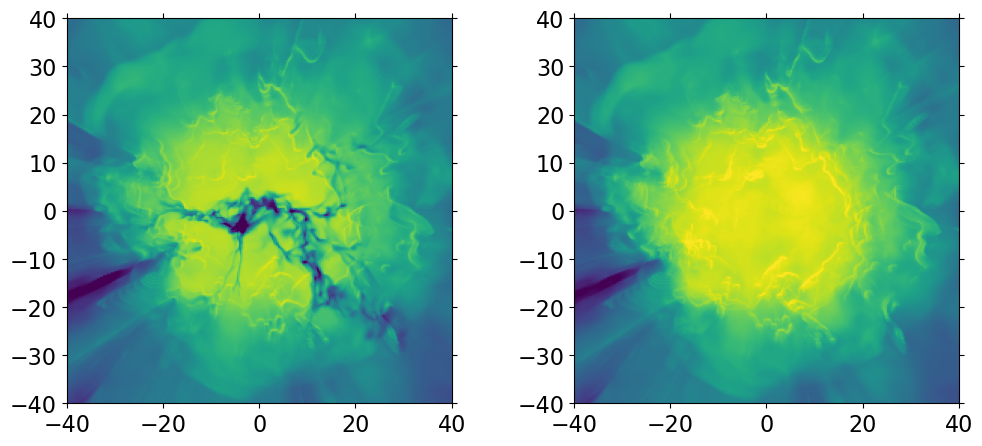

In [27]:
extent = (ds.domain['le'][0],ds.domain['re'][0],
          ds.domain['le'][1],ds.domain['re'][1])
fig,axes = plt.subplots(1,2,figsize=(12,5))
plt.sca(axes[0])
im1 = plt.imshow(I.sum(axis=0), norm=LogNorm(1e-25,1e-20), origin='lower', extent=extent)
plt.sca(axes[1])
im2 = plt.imshow(I_thin.sum(axis=0), norm=LogNorm(1e-25,1e-20), origin='lower', extent=extent)

### First moment ($\int I(v)v dv/ \int I(v) dv$)

In [28]:
Iv = I*v_ch[:,np.newaxis,np.newaxis]
Iv_thin = I_thin*v_ch[:,np.newaxis,np.newaxis]
I.shape, v_ch.shape, Iv.shape

((30, 256, 256), (30,), (30, 256, 256))

Text(0.5, 1.0, '$\\int I_{\\rm thin}(v) v dv / \\int I_{\\rm thin}(v) dv$')

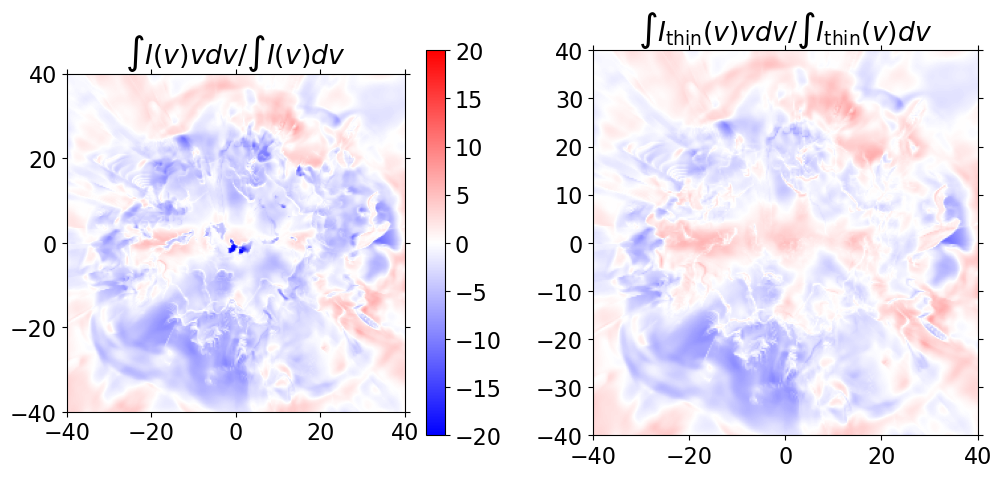

In [33]:
fig,axes = plt.subplots(1,2,figsize=(12,5))
plt.sca(axes[0])
im1 = plt.imshow(Iv.sum(axis=0)/I.sum(axis=0), norm=Normalize(-20,20), extent=extent,
                 cmap=plt.cm.bwr)
plt.title(r'$\int I(v) v dv / \int I(v) dv$')
plt.colorbar(im1)
plt.sca(axes[1])
im1 = plt.imshow(Iv_thin.sum(axis=0)/I_thin.sum(axis=0), norm=Normalize(-20,20), extent=extent,
                 cmap=plt.cm.bwr)
plt.title(r'$\int I_{\rm thin}(v) v dv / \int I_{\rm thin}(v) dv$')

In [31]:
# save to fits file for future use

# from synthetic_Halpha import save_to_fits
# fname_fits = fname_vtk.replace('.vtk','.xy.Halpha.fits')
# hdul = save_to_fits(ds.domain, v_ch, I, I_thin, fname_fits)